In [28]:
%load_ext autotime
from segment_anything import SamAutomaticMaskGenerator, sam_model_registry, SamPredictor
import cv2
import matplotlib.pyplot as plt # Plotting
plt.rcParams['figure.figsize'] = [10, 10]
import numpy as np # Numeric data
import pandas as pd # Tabular data
from rasterio.features import shapes # Vectorising rasters to polygons
from shapely import Point, LineString, Polygon # Geometry
from shapely.geometry import box, shape
from shapely.ops import nearest_points
import geopandas as gpd # Plotting polygons
from tqdm.auto import tqdm # Progress bars
tqdm.pandas()

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime


In [29]:
checkpoint = 'sam_vit_h_4b8939.pth'
sam = sam_model_registry['vit_h'](checkpoint=checkpoint)
# SAM takes 1 min 18 s on a CPU and 15.6s on a P40 GPU, so best to use a GPU
device = 'cuda:0'
sam.to(device)
print("SAM loaded")

SAM loaded


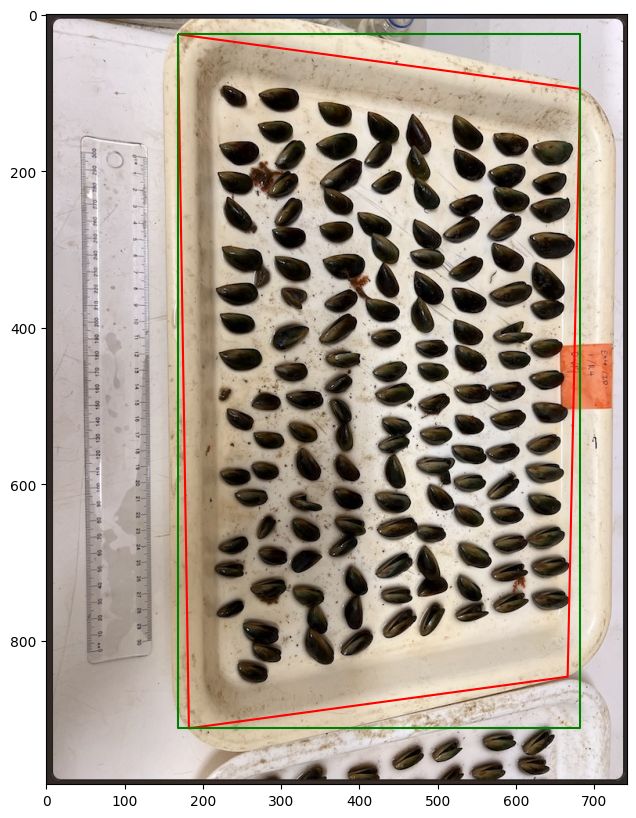

[[ 7.55233380e-01 -2.34138045e-02  3.34545754e+01]
 [-1.28565752e-01  8.90519236e-01  2.31081545e+01]
 [-2.82843434e-04 -6.39497070e-05  1.00000000e+00]]


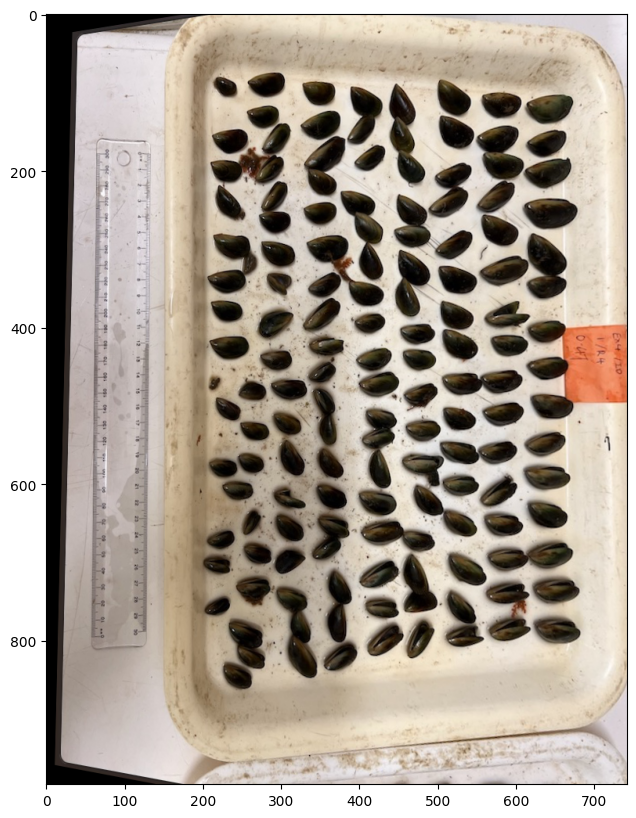

In [30]:
# Reproject trapezoidal tray to rectangular (rectify)
def snap(g1, g2, threshold=1e6):
    coordinates = []
    for x, y in g1.coords:  # for each vertex in the first line
        point = Point(x, y)
        p1, p2 = nearest_points(point, g2)  # find the nearest point on the second line
        if p1.distance(p2) <= threshold:
            # it's within the snapping tolerance, use the snapped vertex
            coordinates.append(p2.coords[0])
        else:
            # it's too far, use the original vertex
            coordinates.append((x, y))
    # convert coordinates back to a LineString and return
    return LineString(coordinates)

img = cv2.cvtColor(cv2.imread('test.png'), cv2.COLOR_BGR2RGB)
masks = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32, # The number of points to be sampled along one side of the image
    min_mask_region_area=100, # If >0, postprocessing will be applied to remove disconnected regions and holes in masks with area smaller than min_mask_region_area
).generate(img)
tray = max(masks, key=lambda x: x["area"])
# Convert binary mask to polygon
tray = shape(next(shapes(tray["segmentation"].astype(np.uint8), mask=tray["segmentation"]))[0])
plt.imshow(img)
trapezoid = snap(tray.envelope.exterior, tray)
bounds = trapezoid.envelope.exterior
gpd.GeoSeries(trapezoid).plot(ax=plt.gca(), color="red")
gpd.GeoSeries(bounds).plot(ax=plt.gca(), color="green")
plt.show()
source_corners = np.float32(trapezoid.coords[:4])
target_corners = np.float32(bounds.coords[:4])
matrix = cv2.getPerspectiveTransform(source_corners, target_corners)
print(matrix)
img = cv2.warpPerspective(img, matrix, (img.shape[1], img.shape[0]), cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=(0,0,0))
plt.imshow(img)

In [31]:
masks = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=50, # The number of points to be sampled along one side of the image
    pred_iou_thresh=0.88, # A filtering threshold in [0,1], using the model's predicted mask quality.
    stability_score_thresh=0.95, # The amount to shift the cutoff when calculated the stability score.
    box_nms_thresh=0.7, # The box IoU cutoff used by non-maximal suppression to filter duplicate masks.
    crop_nms_thresh=0.7, # The box IoU cutoff used by non-maximal suppression to filter duplicate masks between different crops.
    crop_n_layers=0, #  If >0, mask prediction will be run again on crops of the image. Sets the number of layers to run, where each layer has 2**i_layer number of image crops.
    crop_n_points_downscale_factor=1, # The number of points-per-side sampled in layer n is scaled down by crop_n_points_downscale_factor**n.
    min_mask_region_area=100, # If >0, postprocessing will be applied to remove disconnected regions and holes in masks with area smaller than min_mask_region_area
).generate(img)
len(masks)

207

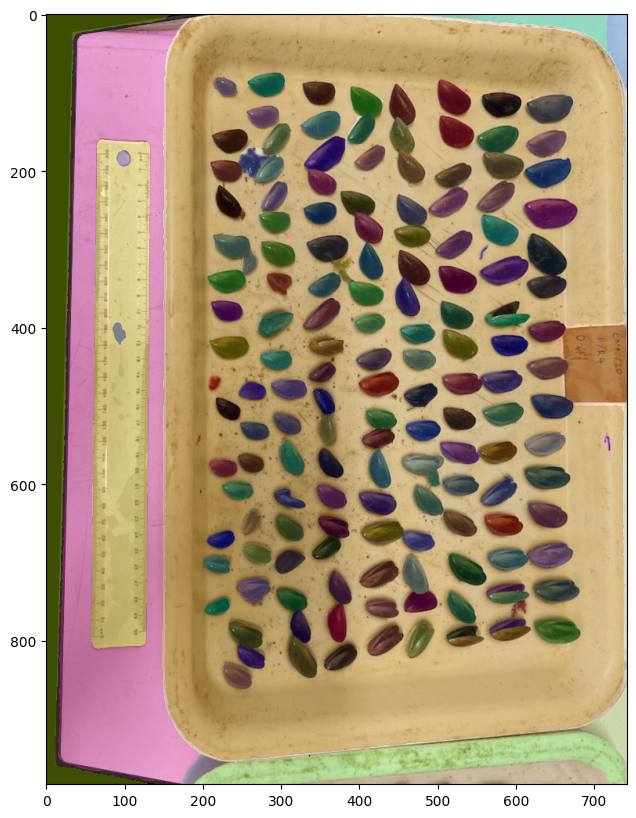

In [32]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

plt.imshow(img)
show_anns(masks)

In [33]:
masks = sorted(masks, key=(lambda x: x['area']), reverse=True)
full_mask = np.zeros_like(masks[0]["segmentation"]).astype(int)
for i in range(len(masks)):
   x, y = np.where(masks[i]['segmentation'])
   full_mask[x,y] = i + 1

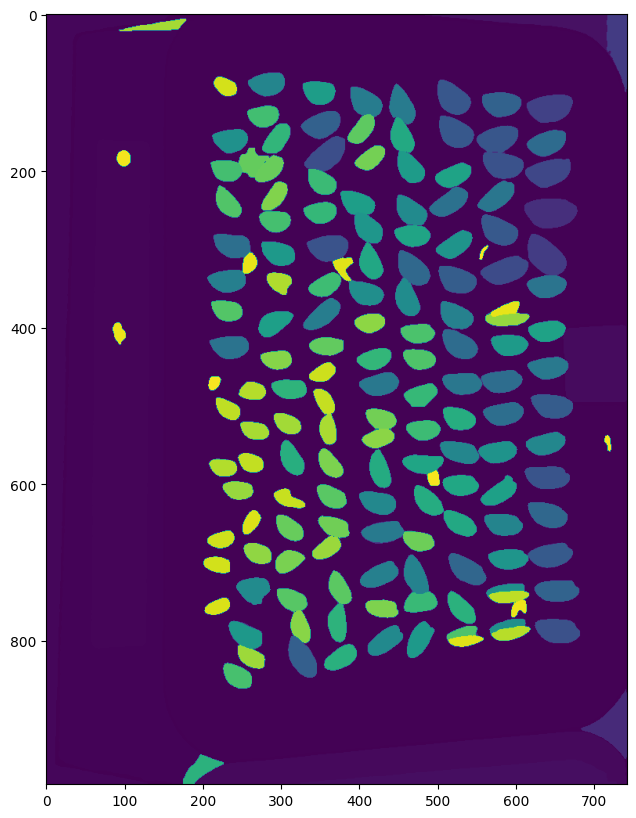

In [34]:
plt.imshow(full_mask)

In [35]:
# Vectorise raster
shape_gen = ((shape(s), v) for s, v in shapes(full_mask.astype(np.uint8), mask=full_mask>0))
# Convert shapes to GeoDataFrame, taking CRS from the image
df = gpd.GeoDataFrame(dict(zip(["geometry", "id"], zip(*shape_gen))))
df

geometry     id
0    POLYGON ((515.000 4.000, 515.000 5.000, 517.00...    7.0
1    POLYGON ((528.000 5.000, 528.000 6.000, 529.00...    7.0
2    POLYGON ((547.000 7.000, 547.000 8.000, 548.00...    7.0
3    POLYGON ((558.000 8.000, 558.000 9.000, 559.00...    7.0
4    POLYGON ((570.000 9.000, 570.000 10.000, 572.0...    7.0
..                                                 ...    ...
736  POLYGON ((0.000 0.000, 0.000 984.000, 130.000 ...    4.0
737  POLYGON ((160.000 20.000, 169.000 20.000, 169....    2.0
738  POLYGON ((197.000 946.000, 199.000 946.000, 19...  133.0
739  POLYGON ((662.000 917.000, 687.000 917.000, 68...    5.0
740  POLYGON ((664.000 953.000, 678.000 953.000, 67...    8.0

[741 rows x 2 columns]

<Axes: >

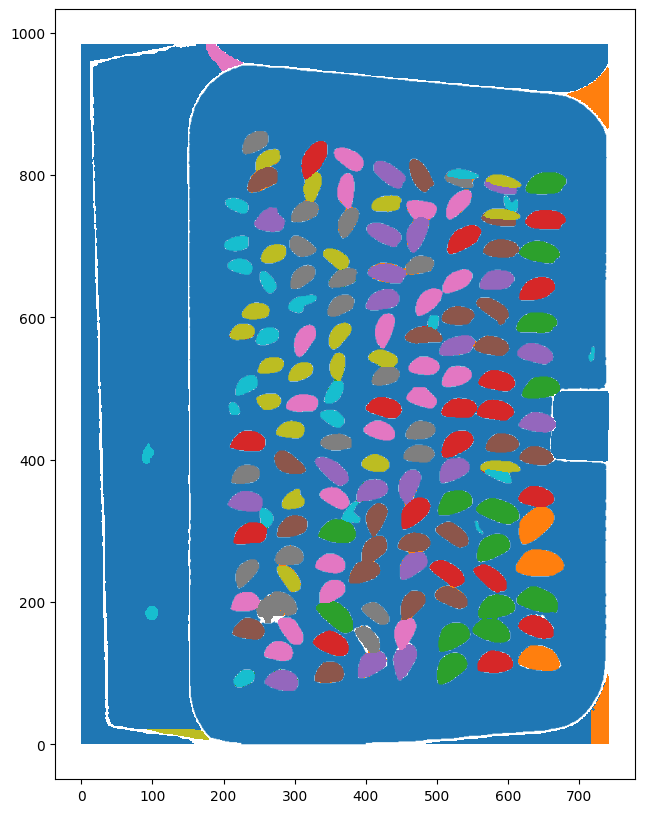

In [36]:
df.plot(column="id", categorical=True)

In [37]:
df["area"] = df.area

<Axes: >

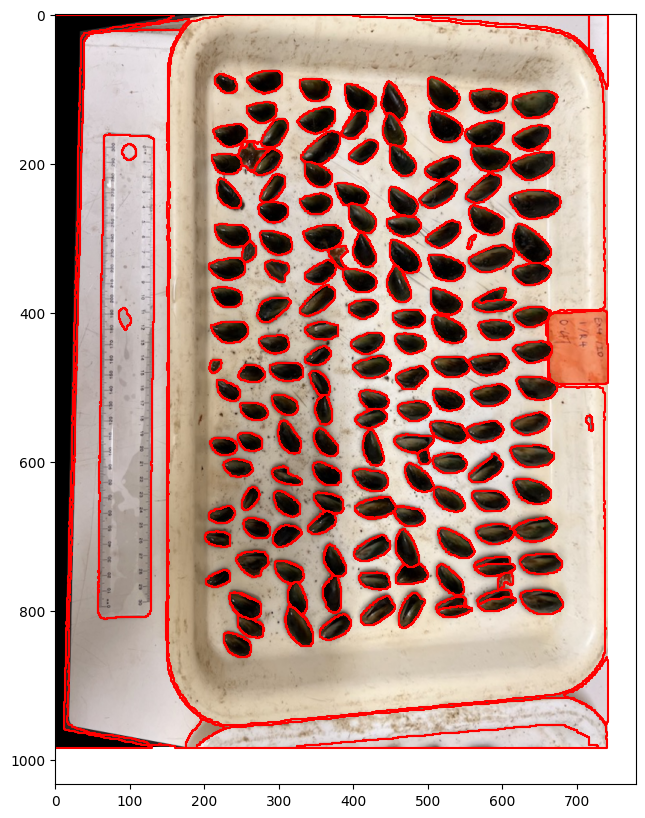

In [38]:
plt.imshow(img)
df.boundary.plot(color="red", ax=plt.gca())

In [39]:
df = df.sort_values(by="area", ascending=False)
df

geometry    id      area
734  POLYGON ((225.000 0.000, 400.000 0.000, 400.00...   1.0  381849.0
737  POLYGON ((160.000 20.000, 169.000 20.000, 169....   2.0   74343.0
689  POLYGON ((71.000 160.000, 74.000 160.000, 74.0...   3.0   44258.0
736  POLYGON ((0.000 0.000, 0.000 984.000, 130.000 ...   4.0   27026.0
739  POLYGON ((662.000 917.000, 687.000 917.000, 68...   5.0   18458.0
..                                                 ...   ...       ...
178  POLYGON ((332.000 196.000, 332.000 197.000, 33...  19.0       1.0
439  POLYGON ((552.000 568.000, 552.000 569.000, 55...  24.0       1.0
182  POLYGON ((357.000 200.000, 357.000 201.000, 35...  19.0       1.0
436  POLYGON ((507.000 562.000, 507.000 563.000, 50...  24.0       1.0
370  POLYGON ((518.000 435.000, 518.000 436.000, 51...  21.0       1.0

[741 rows x 3 columns]

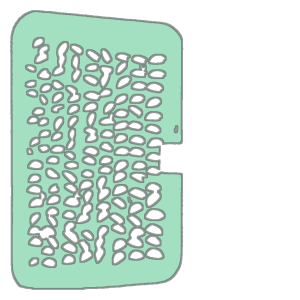

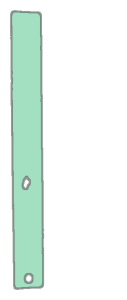

In [40]:
# Tray is largest, then the desk, then the ruler
tray = df.iloc[0]
display(tray.geometry)
ruler = df.iloc[2]
display(ruler.geometry)

In [41]:
ruler

geometry    POLYGON ((71 160, 74 160, 74 161, 85 161, 85 1...
id                                                        3.0
area                                                  44258.0
Name: 689, dtype: object

In [42]:
x1, y1, x2, y2 = ruler.geometry.bounds
ruler_height = y2 - y1
# pixels to cm conversion. ruler is 32cm long
px_per_cm = ruler_height / 32
px_per_cm

20.34375

In [43]:
df["centroid"] = df.centroid

In [44]:
df.iloc[0].centroid.coords[0]

(433.38564065900397, 481.1348268556419)

0it [00:00, ?it/s]

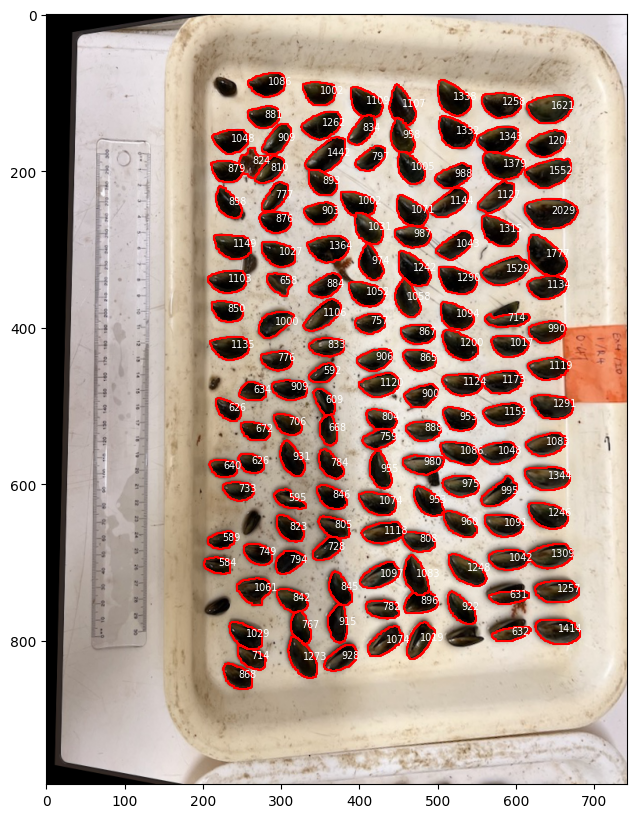

In [45]:
# Filter to just shapes in the tray
df = df[df.within(tray.geometry.envelope.buffer(-5)) & (df.area > 550)]
plt.imshow(img)
df.boundary.plot(ax=plt.gca(), color="red")
for i, row in tqdm(df.iterrows()):
  plt.annotate(round(row.area), row.centroid.coords[0], color="white", fontsize="x-small")

In [46]:
df

geometry     id    area  \
260  POLYGON ((632.000 236.000, 658.000 236.000, 65...   28.0  2029.0   
299  POLYGON ((620.000 281.000, 626.000 281.000, 62...   37.0  1777.0   
86   POLYGON ((647.000 103.000, 663.000 103.000, 66...   40.0  1621.0   
221  POLYGON ((649.000 185.000, 659.000 185.000, 65...   44.0  1552.0   
311  POLYGON ((597.000 309.000, 604.000 309.000, 60...   47.0  1529.0   
..                                                 ...    ...     ...   
401  POLYGON ((344.000 479.000, 353.000 479.000, 35...  189.0   609.0   
467  POLYGON ((304.000 606.000, 307.000 606.000, 30...  190.0   595.0   
381  POLYGON ((358.000 445.000, 364.000 445.000, 36...  191.0   592.0   
517  POLYGON ((229.000 660.000, 236.000 660.000, 23...  192.0   589.0   
560  POLYGON ((214.000 693.000, 219.000 693.000, 21...  193.0   584.0   

                    centroid  
260  POINT (644.588 253.836)  
299  POINT (638.368 309.225)  
86   POINT (644.026 120.060)  
221  POINT (642.322 202.493)  
311  POINT (586.789 327.866)  
..                       ...  
401  POINT (355.758 494.876)  
467  POINT (309.278 620.137)  
381  POINT (353.875 458.458)  
517  POINT (224.293 671.665)  
560  POINT (219.130 703.798)  

[140 rows x 4 columns]

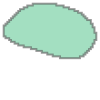

In [47]:
sample = df.sample(1)
poly = sample.geometry.iloc[0]
poly

In [48]:
# Get diameter of polygon by brute force, checking each point pair
def get_diameter(poly):
    max_dist = 0
    coords = [Point(x,y) for x,y in poly.exterior.coords]
    result_coords = []
    for i, a in enumerate(coords):
        for j, b in enumerate(coords):
            if i < j:
                dist = a.distance(b)
                if dist > max_dist:
                    max_dist = dist
                    result_coords = [a, b]

    line = LineString(result_coords)
    return line

line = get_diameter(poly)
line, line.length

(<LINESTRING (451 468, 400 476)>, 51.62363799656123)

Text(425.5, 472.0, '51.62px')

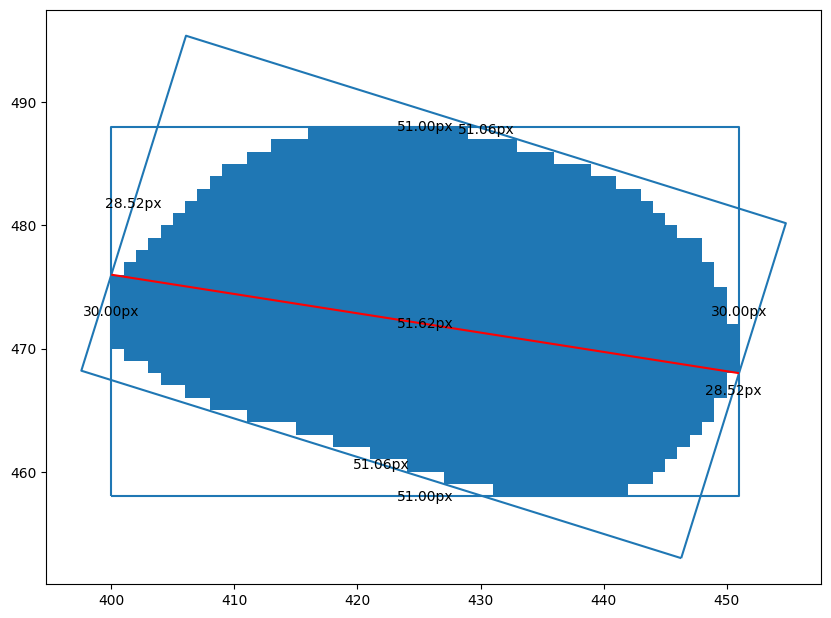

In [49]:
def get_dist(a, b):
    return Point(a).distance(Point(b))

def midpoint(a, b):
    return ((a[0]+b[0])/2, (a[1]+b[1])/2)

def annotate_dist(poly):
    coords = list(poly.exterior.coords)
    for i in range(len(coords)-1):
        a, b = coords[i], coords[i+1]
        dist = get_dist(a, b)
        plt.annotate(f"{dist:.2f}px", xy=midpoint(a, b), ha='center', va='center')

mrr = poly.minimum_rotated_rectangle
bbox = poly.envelope
line = get_diameter(poly)

ax = gpd.GeoSeries([poly, mrr.exterior, bbox.exterior]).plot()
gpd.GeoSeries(line).plot(color="red", ax=ax)
annotate_dist(bbox)
annotate_dist(mrr)
plt.annotate(f"{line.length:.2f}px", xy=midpoint(*list(line.coords)), ha='center', va='center')

In [50]:
df["diameter_line"] = df.geometry.progress_apply(get_diameter)
df["diameter_line"]

  0%|          | 0/140 [00:00<?, ?it/s]

/mnt/nid_env/lib/python3.8/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


260    LINESTRING (679.000 253.000, 611.000 244.000)
299    LINESTRING (620.000 281.000, 659.000 331.000)
86     LINESTRING (673.000 110.000, 614.000 120.000)
221    LINESTRING (670.000 189.000, 612.000 205.000)
311    LINESTRING (616.000 317.000, 555.000 333.000)
                           ...                      
401    LINESTRING (344.000 479.000, 367.000 510.000)
467    LINESTRING (331.000 630.000, 291.000 612.000)
381    LINESTRING (370.000 451.000, 336.000 466.000)
517    LINESTRING (241.000 667.000, 206.000 676.000)
560    LINESTRING (235.000 713.000, 201.000 699.000)
Name: diameter_line, Length: 140, dtype: geometry

In [51]:
ruler.diameter_line = get_diameter(ruler.geometry)

  0%|          | 0/140 [00:00<?, ?it/s]

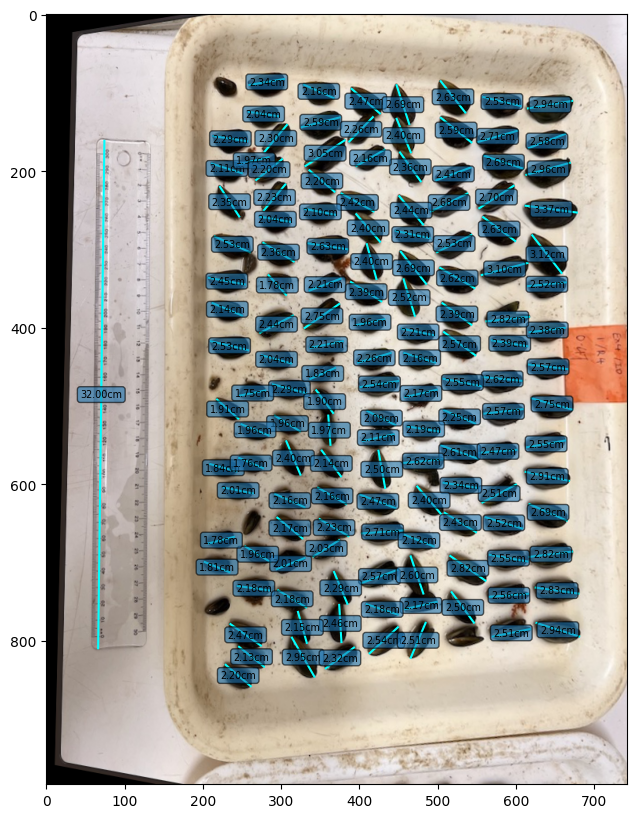

In [52]:
def annotate_length(line):
    x, y = midpoint(*list(line.coords))
    plt.text(s=f"{line.length/px_per_cm:.2f}cm", x=x, y=y, ha='center', va='center', bbox=dict(boxstyle="round", alpha=.6), fontsize="x-small")

plt.imshow(img)
ax = plt.gca()
gpd.GeoSeries(ruler.diameter_line).plot(color="cyan", ax=ax)
annotate_length(ruler.diameter_line)
df.diameter_line.plot(color="cyan", ax=ax)
for line in tqdm(df.diameter_line):
    annotate_length(line)

In [53]:
df["length_cm"] = df.diameter_line.length / px_per_cm
df.length_cm.describe()

/mnt/nid_env/lib/python3.8/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


count    140.000000
mean       2.386273
std        0.308543
min        1.754501
25%        2.164082
50%        2.401067
75%        2.573027
max        3.371699
Name: length_cm, dtype: float64